![Astrofisica Computacional](../logo.PNG)

---
## 01. Motion of a Photon in The Schwarzschild Spacetime I

Eduard Larrañaga (ealarranaga@unal.edu.co)

---

### Summary

In this notebook we implement a code that integrates the equtions of motion of a photon in the Schwarzschild spacetime.


---

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Metric Tensor

\begin{equation}
g_{\mu \nu} = \left[
\begin{matrix}
-\left(1 - \frac{2M}{r} \right) & 0 & 0 & 0\\ 
0 & \left(1 - \frac{2M}{r} \right)^{-1} 0 & 0 &\\
0 & 0 & r^2 & 0\\
0 & 0 & 0 & r^2 \sin^2 \theta  
\end{matrix} 
\right]
\end{equation}

In [6]:
def g(x):
    '''
    This procedure evaluates the Schwarzschild metric 
    tensor in spherical coordinates at a given point.
    '''
    # Coordinates 
    t = x[0]
    r = x[1]
    theta = x[2]
    phi = x[3]
    
    # Metric components
    gtt = -(1. - 2.*M/r)
    grr = 1./(1.- 2.*M/r)
    gthth = r**2
    gphph = r**2 * np.sin(theta)**2
    
    return [gtt, grr, gthth, gphph]

### Equations of Motion

\begin{align}
\dot{t} = &\frac{\varepsilon}{\left( 1 - \frac{2M}{r} \right)}\\
\dot{r} = & \left( 1 - \frac{2M}{r} \right)k_r \\
\dot{\theta} = & \frac{k_\theta}{r^2}\\
\dot{\phi} = & \frac{\ell}{r^2 \sin^2 \theta}\\
\dot{k}_t = & \dot{\varepsilon} = 0\\
\dot{k}_r = & -\frac{M}{(r-2M)^2} \varepsilon^2 - \frac{M}{r^2} k_r^2 + \frac{k_\theta^2}{r^3} + \frac{\ell^2}{r^3 \sin^2 \theta} \\
\dot{k}_\theta = & \frac{ \cos \theta}{r^2 \sin^3 \theta} \ell^2\\
\dot{k}_\phi = & \dot{\ell} =0
\end{align}

In [3]:
def geodesics(q, lmbda):
    '''
    This function contains the geodesic equations 
    in Hamiltonian form for the Schwarzschild metric
    '''
    # Coordinates and momentum components
    t = q[0]
    r = q[1]
    theta = q[2]
    phi = q[3]
    k_t = q[4]
    k_r = q[5]
    k_th = q[6]
    k_phi = q[7]
    
    # Conserved Quantities
    E = - k_t
    L = k_phi
    
    # Geodesics differential equations 
    dtdtau = E*r**2./(r**2 - 2.*M*r)
    drdtau = (1. - 2.*M/r)*k_r
    dthdtau = k_th/r**2
    dphidtau = L/((r**2)*np.sin(theta)**2)
    
    dk_tdtau = 0.
    dk_rdtau = -M*(k_r**2/r**2) + k_th**2/r**3 + L**2/((r**3)*np.sin(theta)**2) - M*(E**2/(r-2.*M)**2) 
    dk_thdtau = (np.cos(theta)/np.sin(theta)**3)*(L**2/r**2)
    dk_phidtau = 0.
    
    return [dtdtau, drdtau, dthdtau, dphidtau, 
              dk_tdtau, dk_rdtau, dk_thdtau, dk_phidtau]

### Initial Conditions

Given the intial values $x^\mu_0 = [0,r_0,\theta_0,\phi_0]$ and $\vec{k}_0 = [k^r_0, k^\theta_0,k^\phi_0]$, this function will give the initial conditions vector $[0,r_0,\theta_0,\phi_0, (k_t)_0, (k_r)_0, (k_\theta)_0, (k_\phi)_0]$ to use in the integration algorithm.

In [4]:
def initCond(x, k, metric):
    '''
    Given the initial conditions (x,k)
    this function returns the list
    [t, r, theta, phi, k_t, k_r, k_theta, k_phi] 
    with the initial conditions needed to solve 
    the geodesic equations 
    (with the covariant components of the momentum vector)
    '''
    
    # Coordinates and momentum components
    t = x[0]
    r = x[1]
    theta = x[2]
    phi = x[3]
    
    kr = k[0]
    kth = k[1]
    kphi = k[2]
    
    g = metric(x)
    
    # Metric components
    g_tt = g[0]
    g_rr = g[1]
    g_thth = g[2]
    g_phph = g[3]
    
    kt = np.sqrt(-(delta + g_rr*kr**2 + g_thth*kth**2 + g_phph*kphi**2)/g_tt)
    
    # Lower k-indices
    k_t = g_tt*kt 
    k_r = g_rr*kr
    k_th = g_thth*kth
    k_phi = g_phph*kphi
    
    return [t, r, theta, phi, k_t, k_r, k_th, k_phi]

### Plot

We implement two plotting functions,

In [30]:
def plot(sol, ps=False, ISCO=False):
    indx = len(sol[:,1])
    for i in range(indx):
        if sol[i,1]<2.+1e-10: 
            indx = i
            break
    x = sol[:indx,1]*np.cos(sol[:indx,3])
    y = sol[:indx,1]*np.sin(sol[:indx,3])
    
    BH = plt.Circle((0, 0), 2*M, color='k')
    psp = plt.Circle((0, 0), 3*M, fill=False, linestyle=':', label='Photon Sphere')
    ISCO = plt.Circle((0, 0), 6*M, fill=False, linestyle='--', label='ISCO')
    
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.add_patch(BH)
    if ps==True:
        ax.add_patch(psp)
    if ISCO==True:
        ax.add_patch(ISCO)
    ax.plot(x,y, color='crimson', label='Test particle')
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.grid(alpha=0.2)
    ax.axvline(0, c='k', alpha=0.1)
    ax.axhline(0, c='k', alpha=0.1)
    plt.legend()
    plt.show()

def plot3D(sol):
    x = sol[:,1]*np.sin(sol[:,2])*np.cos(sol[:,3])
    y = sol[:,1]*np.sin(sol[:,2])*np.sin(sol[:,3])
    z = sol[:,1]*np.cos(sol[:,2])
    
    # draw black hole
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    xs = 2*M*np.cos(u)*np.sin(v)
    ys = 2*M*np.sin(u)*np.sin(v)
    zs = 2*M*np.cos(v)
    
    ax = plt.figure().add_subplot(projection='3d')
    ax.plot_surface(xs, ys, zs, color='k')
    ax.plot(x, y, z, color='crimson')
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    ax.set_zlim(-15,15)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$z$')
    plt.show()

---
## Integration of the Equations of Motion

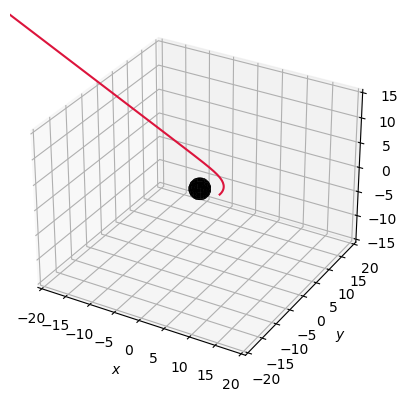

In [36]:
M = 1
delta = 0 # 0: photon o 1: particula con masa

# Initial Conditions
t0 = 0.
r0 = 4*M
theta0 = np.pi/2
phi0 = 0.

kr0 = 0.
kth0 = 0.
kphi0 = 1.

x = [t0, r0, theta0, phi0]
k = [kr0, kth0, kphi0]

q = initCond(x, k, g)


lmbda = np.linspace(0,40,400)

sol = odeint(geodesics, q, lmbda)
plot3D(sol)

## Photon Sphere and the Shadow of the Black Hole

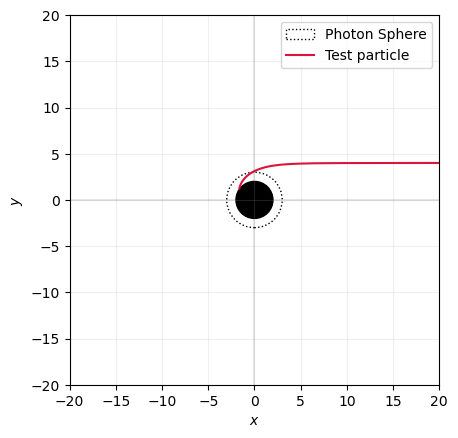

In [34]:
M = 1
delta = 0

t0 = 0.
theta0 = np.pi/2
kth0 = 0.


# Initial Conditions

x0 = 20
y0 = 4
r0 = np.sqrt(x0**2 + y0**2)
phi0 = np.arctan(y0/x0)

v0 = 1
kr0 = -v0*np.cos(phi0)
kphi0 = v0*np.sin(phi0)/r0

x = [t0, r0, theta0, phi0]
k = [kr0, kth0, kphi0]

ic = initCond(x, k, g)

lmbda = np.linspace(0,50,400)
sol = odeint(geodesics, ic, lmbda)
plot(sol, ps=True)

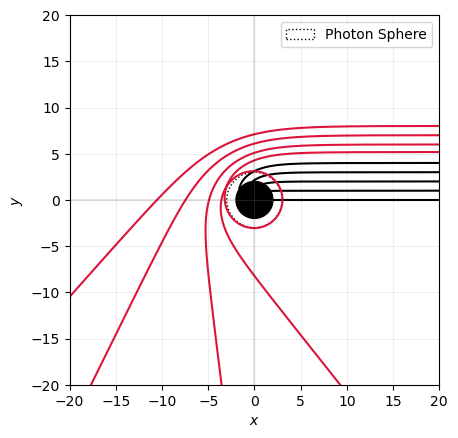

In [35]:
def plotmany(p_coords):
    BH = plt.Circle((0, 0), 2*M, color='k')
    ps = plt.Circle((0, 0), 3*M, fill=False, linestyle=':', label='Photon Sphere')
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.add_patch(BH)
    ax.add_patch(ps)
    
    lmbda = np.linspace(0,60,500)
    for p in p_coords:
        color = 'crimson'
        sol = odeint(geodesics, p, lmbda)
        indx = len(sol[:,1])
        for i in range(indx):
            if sol[i,1]<2.+1e-10: 
                indx = i
                color = 'black'
                break
        x = sol[:indx,1]*np.cos(sol[:indx,3])
        y = sol[:indx,1]*np.sin(sol[:indx,3])
        ax.plot(x,y, color=color)

    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.grid(alpha=0.2)
    ax.axvline(0, c='k', alpha=0.1)
    ax.axhline(0, c='k', alpha=0.1)
    plt.legend()
    plt.show()

    
M = 1
delta = 0

t0 = 0.
theta0 = np.pi/2
kth0 = 0.

yy = [0,1,2,3,4,5.181,6,7,8]
p_coords = []

# Initial Conditions
for y0 in yy:
    x0 = 20
    
    r0 = np.sqrt(x0**2 + y0**2)
    phi0 = np.arctan(y0/x0)

    v0 = 1
    kr0 = -v0*np.cos(phi0)
    kphi0 = v0*np.sin(phi0)/r0

    x = [t0, r0, theta0, phi0]
    k = [kr0, kth0, kphi0]

    ic = initCond(x, k, g)
    p_coords.append(ic)

    
plotmany(p_coords)